In [53]:
# Базовые библиотеки
import numpy as np
import pandas as pd

# Воспроизводимость
RANDOM_STATE = 42

# Библиотеки sklearn для данных, моделей, разбиения и метри
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
)

# Для калибровки
from sklearn.calibration import CalibratedClassifierCV

In [54]:
df = pd.read_csv("S05-hw-dataset.csv")

print("HEAD:\n", df.head())
print("INFO\n", df.info())
print("DESCRIBE\n", df.describe())


HEAD:
    client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1  

In [55]:
df["default"].value_counts(normalize=True)

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

In [56]:
# Выделим матрицу признаков X и вектор таргета y
X = df.drop(columns=["client_id", "default"])
y = df["default"]

print("Форма X:", X.shape)
print("Форма y:", y.shape)

display(X.head())

Форма X: (3000, 15)
Форма y: (3000,)


,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10


In [57]:
# 1. Отделяем тестовую выборку (например, 20% данных)
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,          # важно для классификации: сохраняем долю классов
    random_state=RANDOM_STATE,
)

# 2. Делим оставшиеся данные на train и validation (например, 60/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,      # 0.25 от X_temp = 0.25 * 0.8 = 0.2 от исходных
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print("Размеры выборок:")
print("  train:", X_train.shape)
print("  val:  ", X_val.shape)
print("  test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов (val):")
print(y_val.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
  train: (1800, 15)
  val:   (600, 15)
  test:  (600, 15)

Распределение классов (train):
default
0    0.589444
1    0.410556
Name: proportion, dtype: float64

Распределение классов (val):
default
0    0.59
1    0.41
Name: proportion, dtype: float64

Распределение классов (test):
default
0    0.59
1    0.41
Name: proportion, dtype: float64


In [58]:
# Бейзлайн-модель
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

# Обучаем только на train
baseline.fit(X_train, y_train)

# Оцениваем на validation
y_val_pred_baseline = baseline.predict(X_val)
y_val_proba_baseline = baseline.predict_proba(X_val)[:, 1]

print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred_baseline))
print("Precision:", precision_score(y_val, y_val_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred_baseline, zero_division=0))

# Для ROC-AUC нам нужны вероятности положительного класса
try:
    print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba_baseline))
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)

=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===
Accuracy : 0.59
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.5


In [59]:
# Собираем Pipeline:
# 1) Масштабирование признаков (StandardScaler)
# 2) Логистическая регрессия
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                penalty="l2",
                C=1.0,              # сила регуляризации (чем меньше C, тем сильнее регуляризация)
                solver="liblinear", # надёжный солвер для маленьких датасетов
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

# Обучаем pipeline на train
log_reg_pipeline.fit(X_train, y_train)

# Предсказываем на validation
y_val_pred = log_reg_pipeline.predict(X_val)
y_val_proba = log_reg_pipeline.predict_proba(X_val)[:, 1]

print("=== Логистическая регрессия (C=1.0) – качество на validation ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba))

=== Логистическая регрессия (C=1.0) – качество на validation ===
Accuracy : 0.8166666666666667
Precision: 0.8505154639175257
Recall   : 0.6707317073170732
F1-score : 0.75
ROC-AUC  : 0.8746382802811079


C:\Users\vnars\Desktop\AIE-course\PythonHW05\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [60]:
# Настроим сетку по параметру C (сила регуляризации)
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

# GridSearchCV будет:
# - внутри делать кросс-валидацию по train
# - выбирать лучший C по заданной метрике (например, ROC-AUC).
grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",    # можно поменять на f1, recall и т.д.
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (по CV):", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'logreg__C': 0.1}
Лучший ROC-AUC (по CV): 0.8535885101695057


C:\Users\vnars\Desktop\AIE-course\PythonHW05\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


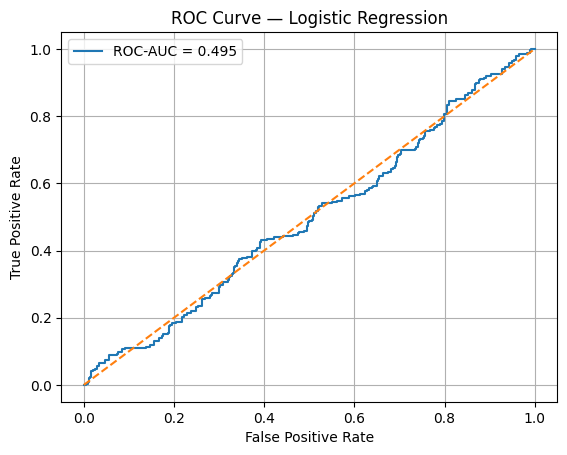

In [63]:
# Графики
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, _ = roc_curve(y_test, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.grid(True)
plt.savefig("figures/roc_curve.png")
plt.show()

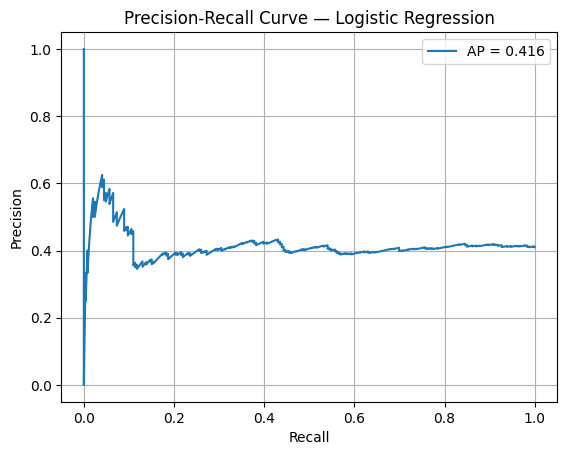

In [64]:
precision, recall, _ = precision_recall_curve(y_test, y_val_proba)
avg_precision = average_precision_score(y_test, y_val_proba)

plt.figure()
plt.plot(recall, precision, label=f"AP = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Logistic Regression")
plt.legend()
plt.grid(True)
plt.savefig("figures/pr_curve.png")
plt.show()